# ssp.train.py

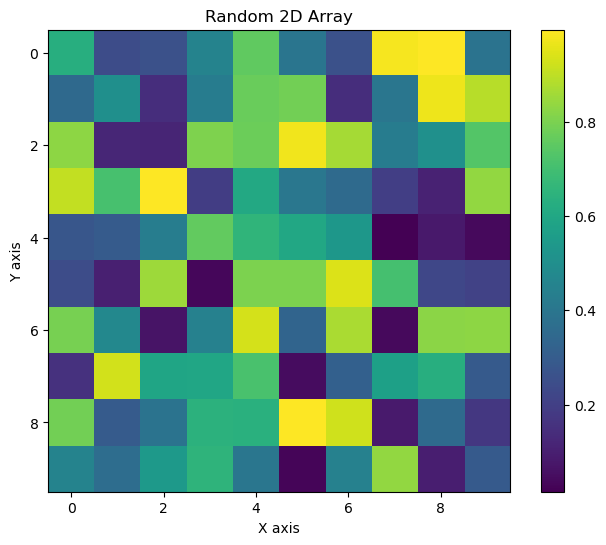

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen


# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = 3,
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 

    converted_net_forward = False,

    pretrained_net = None, 
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'
    if converted_net_forward == True:
        assert SAE_net == False, 'converted_net_forward는 SAE_net이 False일 때만 가능'
    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    # tem=10
    # cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= f'{gpu}'


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)



    # 모델 초기화
    if SAE_net == False: # 여기서는 l2norm, lif bridge 둘 다 true면 l2norm먼저
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge)
            net = torch.nn.DataParallel(net)
            converted_net = SAE_converted_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last) # lif bridge는 무조건 들어가게 해놨음.
            converted_net = torch.nn.DataParallel(converted_net)
            print('converted_net', converted_net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[400, lateral_feature_num], decoder_ch=[400,n_sample], n_sample=n_sample, need_bias=need_bias, l2norm_bridge=sae_l2_norm_bridge, relu_bridge=sae_lif_bridge)
            net = torch.nn.DataParallel(net)
            converted_net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last) # lif bridge는 무조건 들어가게 해놨음.
            converted_net = torch.nn.DataParallel(converted_net)
            print('converted_net', converted_net)
    else: # 여기서는 l2norm, lif bridge 둘 다 true면 lif또는 relu먼저
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)
        else:
            net = SAE_fc_only(encoder_ch=[400, lateral_feature_num], 
                                decoder_ch=[400, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_annbase_20250108_210641_941.pth'))
    if pretrained_net != None:
        net.module.load_state_dict(torch.load(pretrained_net))




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
        
    k_means_acc_best = 0
    for epoch in range(max_epoch):
        print()
        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        if max_epoch != 1:
            for data in train_loader:
                optimizer.zero_grad()
                spike_backup = data
                spike = data
                spike = zero_to_one_normalize_features(spike) if normalize_on else spike
                spike = spike.to(device) # batch, feature
                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                    spike = (spike > levels).to(torch.float) 

                    spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                    # spike: batch, time, level_num
                    # levels: time, level_num
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        if two_channel_input == True:
                            spike_backup = spike_backup.to(device)
                            spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_backup = (spike_backup <= levels).to(torch.float) 
                            spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                            spike_backup = spike_backup.unsqueeze(-2)
                            spike = torch.cat((spike, spike_backup), dim=-2)
                    assert spike.shape[0] == batch_size and spike.shape[1] == TIME
                elif 'SAE' in net.module.__class__.__name__:
                    spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                else:
                    if Conv_net == True:
                        spike = spike.unsqueeze(-2) #batch in_channel,feature

                # for i in range (3):
                #     plot_spike(spike[i,:,0,:].cpu().numpy())
                #     plot_spike(spike[i,:,1,:].cpu().numpy())
                # assert False
                        
                spike_class = net(spike) # batch, time, feature

                if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                    # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                    # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                    # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                    # loss = loss1 * 2.125 + (loss2 + loss3)/4

                    loss = nn.MSELoss()(spike_class, spike)
                elif 'SAE' in net.module.__class__.__name__:
                    loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'
                else:
                    loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                    loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                    loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                    loss = loss1 * 2.125 + (loss2 + loss3)/4
                    assert spike_length > 25, 'spike_length가 25보다 작음'
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
                iter += 1
        else:
            print('\n\n\n max_epoch 1이면 Train 안함!!!!!!!!!!!!!!!!!!!!!')
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초")



        if SAE_net == False:
            source_encoder = net.module.encoder 
            target_encoder = converted_net.module.encoder  
            copy_weights(source_encoder, target_encoder)

        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        k_means_acc = 0
        converted_k_means_acc = 0
        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            k_means_bin_origin_feature = []
            k_means_bin = []
            converted_k_means_bin = []
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                spike_template = zero_to_one_normalize_features(spike_template) if normalize_on else spike_template
                spike = zero_to_one_normalize_features(spike) if normalize_on else spike
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                


                net.eval()
                with torch.no_grad():
                    spike_torch = torch.from_numpy(spike_template).float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                        if converted_net_forward == True:
                            spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                    ### forward #######################################################
                    inner_inf = net.module.encoder(spike_torch)
                    if SAE_net == False and converted_net_forward == True:
                        converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                    ### forward #######################################################

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                converted_spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = torch.from_numpy(spike_batch)
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                            if converted_net_forward == True:
                                spike_torch_spikegen = spikegen.rate(spike_torch, num_steps=TIME).transpose(0, 1)
                                
                        ### forward #######################################################
                        inner_inf = net.module.encoder(spike_torch)
                        if SAE_net == False and converted_net_forward == True:
                            converted_inner_inf = converted_net.module.encoder(spike_torch_spikegen)
                        ### forward #######################################################
                            
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        if SAE_net == False and converted_net_forward == True:
                            converted_spike_hidden[now_index:now_end_index] = converted_inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 2), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16

                origin_kmeans_accuracy = cluster_spikes_with_accuracy(features= spike, true_labels=label-1, n_clusters=3, init_point=None)
                kmeans_accuracy = cluster_spikes_with_accuracy(features= spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                k_means_bin_origin_feature.append(origin_kmeans_accuracy)
                k_means_bin.append(kmeans_accuracy)
                if SAE_net == False and converted_net_forward == True:
                    converted_kmeans_accuracy = cluster_spikes_with_accuracy(features= converted_spike_hidden, true_labels=label-1, n_clusters=3, init_point=None)
                    converted_k_means_bin.append(converted_kmeans_accuracy)

                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time() 
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])
            print(f'k_means origin feature average accuracy : {100*sum(k_means_bin_origin_feature)/len(k_means_bin_origin_feature):.8f}%, total {k_means_bin_origin_feature}')
            if SAE_net == False and converted_net_forward == True:
                converted_k_means_acc = 100*sum(converted_k_means_bin)/len(converted_k_means_bin)
                print(f'converted_kmeans average accuracy : {converted_k_means_acc:.8f}%, total {converted_k_means_bin}')
            k_means_acc = 100*sum(k_means_bin)/len(k_means_bin)
            k_means_acc_best = max(k_means_acc_best, k_means_acc)
            print(f'kmeans average accuracy best : {k_means_acc_best:.2f}%, kmeans average accuracy : {k_means_acc:.8f}%, total {k_means_bin}')
            print(f'cluster_accuracy_post_training_cycle_all_dataset : {cluster_accuracy_post_training_cycle_all_dataset}')


            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.8f}%")

            if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"k_means_acc": k_means_acc})
        wandb.log({"converted_k_means_acc": converted_k_means_acc})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

# gpu = 4
# Conv_net = True
# SAE_net = False

# # hyperparameter
# dataset_num = 16
# spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 2400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 1
# learning_rate = 0.001
# normalize_on = True # True or False # 0부터1까지 normalize
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 1000 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
# v_decay = 1.0 # -cor
# v_threshold = 0.5 # -cor
# v_reset = 0.0 # -cor # 10000 이상 일 시 hard reset
# BPTT_on = True # +cor

# SAE_hidden_nomean = True # True False

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'SGD' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

# coarse_com_mode = False
# coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0 -3.0)

# sae_l2_norm_bridge = True # True False
# sae_lif_bridge = True # False True

# accuracy_check_epoch_term = 1

# lif_add_at_last = False # True False

# two_channel_input = False # True False

# lateral_feature_num = 4

# lc_adc_on = False # True False

# converted_net_forward = True # True False


# # pretrained_net = None
# pretrained_net = '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250110_203117_390.pth'

# wandb.init(project= f'spike_sorting just run',save_code=False)


# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
    
#     current_time = current_time,

#     optimizer = optimizer, #'Adam', 'SGD'

#     coarse_com_mode = coarse_com_mode,
#     coarse_com_config = coarse_com_config, # (max, min)

    
#     sae_l2_norm_bridge = sae_l2_norm_bridge,
#     sae_lif_bridge = sae_lif_bridge,

#     accuracy_check_epoch_term = accuracy_check_epoch_term,
    
#     lif_add_at_last = lif_add_at_last,

#     two_channel_input = two_channel_input,

#     lateral_feature_num = lateral_feature_num,

#     lc_adc_on = lc_adc_on, 

#     converted_net_forward = converted_net_forward,

#     pretrained_net = pretrained_net,
#     )



In [4]:
# Sweep code


from unittest import TextTestRunner


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'grid', # 'random', 'bayes' 'grid'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'converted_k_means_acc'},
    'parameters': 
    {
        # "gpu": {"values": [1]},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [True]}, 
        "SAE_net": {"values": [False]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [2400]}, # [1400, 2400]

        "batch_size": {"values": [32]}, 
        "max_epoch": {"values": [1]}, 
        "learning_rate": {"values": [0.001]},
        "normalize_on": {"values": [True]},
        "need_bias": {"values": [False]}, # [True, False]

        "lif_add_at_first": {"values": [False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [10, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}, #  [4,6,8,10]
        "v_decay": {"values": [1.0]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.125, 0.25, 0.50, 0.75, 0.875, 1.0, 1.25, 1.5, 1.75,2.0,2.25,2.5]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True]}, # [True, False]

        # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

        "optimizer": {"values": ['SGD']}, # ['Adam', 'SGD']

        "coarse_com_mode": {"values": [False]}, # [True, False]
        "coarse_com_config": {"values": [(2.0, -2.0)]}, # ['Adam', 'SGD']

        "sae_l2_norm_bridge": {"values": [True]}, # [True, False]
        "sae_lif_bridge": {"values": [True]}, # [False, True]
        
        "accuracy_check_epoch_term": {"values": [1]}, 

        "lif_add_at_last": {"values": [False]},# [True, False]

        "two_channel_input": {"values": [False]},# [True, False]

        "lateral_feature_num": {"values": [4]},# [True, False]

        "lc_adc_on": {"values": [False]},# [True, False]
        
        "converted_net_forward": {"values": [True]},# [True, False]

        "pretrained_net": {"values": ['/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_중요_20250113_134126_881.pth']},# [None]

     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  0
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer

    coarse_com_mode = wandb.config.coarse_com_mode
    coarse_com_config = wandb.config.coarse_com_config # (max, min)

    sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
    sae_lif_bridge = wandb.config.sae_lif_bridge

    accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

    lif_add_at_last = wandb.config.lif_add_at_last

    two_channel_input = wandb.config.two_channel_input

    lateral_feature_num = wandb.config.lateral_feature_num

    lc_adc_on = wandb.config.lc_adc_on

    converted_net_forward = wandb.config.converted_net_forward

    pretrained_net = wandb.config.pretrained_net


    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'

        coarse_com_mode = coarse_com_mode,
        coarse_com_config = coarse_com_config, # (max, min)
        
        sae_l2_norm_bridge = sae_l2_norm_bridge,
        sae_lif_bridge = sae_lif_bridge,

        accuracy_check_epoch_term = accuracy_check_epoch_term,

        lif_add_at_last = lif_add_at_last,
        
        two_channel_input = two_channel_input,
        
        lateral_feature_num = lateral_feature_num,

        lc_adc_on = lc_adc_on,

        converted_net_forward = converted_net_forward,

        pretrained_net = pretrained_net,

        )
    
# sweep_id = 'ygoj9jt4'
sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: mw0jwdst
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/spike_sorting%20cluster_train_system/sweeps/mw0jwdst


wandb: Agent Starting Run: del287c0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_234607_844', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,35.78319
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: r85b4vod with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_234707_461', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.46720870%, total [0.3466135458167331, 0.36201022146507666, 0.35202761000862814, 0.3408175014392631, 0.34222873900293255, 0.3443181818181818, 0.3465259454705365, 0.33664208735110607, 0.3437777120898611, 0.3407772621809745, 0.34389400921658986, 0.34885764499121263, 0.3370986920332937, 0.34286539572501445, 0.34418604651162793, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.90499

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.46721
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ytycde2o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_234800_461', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: s1gy72nj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_234853_278', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 4zefi2fz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_234947_461', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: cds8v274 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name o

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235040_215', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel(

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 59red5ay with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235133_112', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: as9unfke with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235226_325', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 0e7m9r9y with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235319_845', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: vinw2o44 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name o

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235411_966', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel(

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: esc7hmim with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235505_389', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: xjv1r18d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235559_489', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: v5tl2o43 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235651_813', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.23740676%, total [0.3392145702902675, 0.3532084043157297, 0.3425366695427092, 0.3416810592976396, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3420041383387526, 0.33700696055684454, 0.33986175115207373, 0.3450497949619215, 0.3376932223543401, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.904991491

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.23741
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 6hro48gg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235744_911', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: aplidlej with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235837_139', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: owuegmw2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250114_235930_677', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: y8m7ozug with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.875
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000023_554', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 1oe0qoqf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000118_099', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ckcyzrs8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000210_074', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: t1p1llgc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000302_263', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: xc8cko0j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000355_995', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ewfjztze with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_r

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000458_718', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: r31ld7em with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000557_092', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lep3gkrb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 10
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 10, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000652_617', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 34.22488434%, total [0.3392145702902675, 0.35122089721749006, 0.34167385677308026, 0.34484743811168683, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.3414129470883831, 0.3375870069605568, 0.33755760368663595, 0.3453427065026362, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,34.22488
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 5ap5vbgf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000744_072', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,79.28155
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aoveyl94 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_000907_815', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,85.32657
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: rpfnmp8g with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001029_195', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,82.40678
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 39wecijy with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001149_101', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,72.96357
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 0l3u3b4k with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001306_765', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,65.09726
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: obgl0c2v with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001427_023', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,64.04657
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nf5airkz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001547_336', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,56.98672
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: vbmhb37s with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001708_700', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,53.19133
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: w1jvwm8d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).


{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001831_548', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}


wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'my_seed' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_threshold' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'v_reset' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'BPTT_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_hidden_nomean' w

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel(
  (module): SAE_converted_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_mul_vth()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_mul_vth()
      (11): SSBH_DimChanger_for_one_two_coupling()
      (12): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (13): SSBH_DimChanger_for_one_two_decoupling()
      (14): LIF_layer()
      (15): SSBH_mul_vth()
      (16): SSBH_DimChanger_for_one_two_coupling()
      (17

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,47.40905
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 9f9f11d5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_001952_874', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,43.24598
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gahxczpf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002109_160', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 43.95012534%, total [0.5466704610130905, 0.5610448608745031, 0.550186942766753, 0.5472078295912493, 0.3428152492668622, 0.34460227272727273, 0.346819114629141, 0.3372093023255814, 0.4986698196866686, 0.5243619489559165, 0.5411866359447005, 0.505858230814294, 0.3460166468489893, 0.3509532062391681, 0.35174418604651164, 0.3366733466933868]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.904991491775382

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,43.95013
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gomsi4nf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002228_256', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 45.29098627%, total [0.5759817871371656, 0.5795002839295854, 0.5614035087719298, 0.551237766263673, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.5441915459651198, 0.5913573085846868, 0.5671082949308756, 0.5371997656707674, 0.3373959571938169, 0.3443096476025419, 0.34505813953488373, 0.34154022330375033]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.904991491775

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,45.29099
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gbh64nf0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002347_874', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,83.77893
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bwsjcwlf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002513_064', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,80.6867
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dg01abno with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002645_941', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,68.96131
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zruzw1we with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002819_961', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,60.72284
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lrqhcjkf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.875
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_002940_657', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,59.38333
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 8149ziu3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003104_605', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,56.92372
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: d7jllfk4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003226_968', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,54.02932
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vqodw5v8 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003359_443', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,46.46035
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: dmel11f2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003520_736', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 43.78920440%, total [0.5432555492316449, 0.5530948324815446, 0.547310900201323, 0.5359815774323546, 0.34428152492668623, 0.34602272727272726, 0.346819114629141, 0.33834373227453207, 0.4360035471475022, 0.48839907192575405, 0.5172811059907834, 0.5114235500878734, 0.3870392390011891, 0.37954939341421146, 0.37761627906976747, 0.3538505582593759]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.9049914917

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,43.7892
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: sn204oyq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003642_080', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 45.10505623%, total [0.6254980079681275, 0.5908574673480976, 0.5660051768766178, 0.5610247553252734, 0.34252199413489737, 0.34488636363636366, 0.346819114629141, 0.33664208735110607, 0.5128584096955365, 0.531322505800464, 0.5483870967741935, 0.5272407732864675, 0.3445303210463734, 0.3512420566146736, 0.35087209302325584, 0.33610077297452046]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.90499149177

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,45.10506
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 7ii8a53l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003801_710', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 44.14604707%, total [0.5614684120660216, 0.5579216354344123, 0.5372447512223181, 0.52475532527346, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.5341412947088383, 0.5466937354988399, 0.5420506912442397, 0.5213825424721734, 0.3373959571938169, 0.3437319468515309, 0.3447674418604651, 0.34154022330375033]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.90499149177538

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,44.14605
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ny7ipnf2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 100
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 100, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_003921_085', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  re

k_means origin feature average accuracy : 80.22435171%, total [0.9746727376209448, 0.9733106189664963, 0.9700891573195284, 0.9530800230282096, 0.943108504398827, 0.9147727272727273, 0.7988859571973028, 0.6639251276233693, 0.6420336979012711, 0.8216357308584686, 0.5855414746543779, 0.4903339191564148, 0.9429250891795482, 0.8922588099364529, 0.6744186046511628, 0.5949040939020899]
converted_kmeans average accuracy : 39.53990480%, total [0.4487763232783153, 0.4619534355479841, 0.44808743169398907, 0.42918825561312607, 0.34222873900293255, 0.34488636363636366, 0.346232776311932, 0.3369256948383437, 0.4575820277859888, 0.45069605568445475, 0.4547811059907834, 0.4381956649091974, 0.3373959571938169, 0.34286539572501445, 0.3444767441860465, 0.34211279702261665]
kmeans average accuracy best : 94.43%, kmeans average accuracy : 94.42764735%, total [0.9769493454752419, 0.9775695627484384, 0.9741156169111302, 0.973517559009787, 0.9686217008797654, 0.9673295454545454, 0.9530929346232776, 0.90499149

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,39.5399
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kl97zeip with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_004054_331', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,80.78267
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 9vy4spav with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_004249_626', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.16964
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: u20ur1gh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_004438_731', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.56223
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 4c75kpdw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_004633_117', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.64739
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bt54762f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_004823_238', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.01917
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: k2o8kmat with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005013_835', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.0885
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qm5r38tz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005205_358', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,83.10025
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: hrnd0jvz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005356_255', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,79.66452
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: rvb6he4o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005549_095', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,77.16004
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oap1l2qm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005749_504', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,72.20821
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: a7i77829 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_005939_599', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,67.03728
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: glr3wrrk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_010131_218', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,63.45776
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: u2w68aiq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_010322_662', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.95513
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pqfi09in with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_010535_837', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.62617
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: p2udm89d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_010744_235', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.60318
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bivyexvx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_010952_863', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.14963
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i7xg1twb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_011204_805', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,81.35171
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 1d8omjvt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_011415_214', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,80.0456
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: dl8hluwh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_011619_645', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,82.95783
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nb1qqt37 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_011827_159', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,71.51543
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ne8vm0nu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_012035_180', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,70.9733
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 7g2qvlir with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_012241_340', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,62.66323
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 9sb8inmr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_012448_558', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,64.72558
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 08n31qog with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 250
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 250, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_012655_034', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,62.40292
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qzrkrn6o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_012903_215', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,85.05526
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gr3zz2jq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_013152_650', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.77108
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 3a747imj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_013442_281', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.34923
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lka00wz6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_013729_653', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.19058
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: yjqpnry7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_014016_826', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.06588
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vvbzr5q1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_014313_742', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.95015
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 6og99oy5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_014603_281', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.26256
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: m3c6v8lz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_014851_199', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.26082
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwmcr84e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_015146_992', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.39605
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: pwi9u83b with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_015436_430', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,83.27316
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: d06immyn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_015722_780', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.0411
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: scdpuu3l with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_020008_825', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.40749
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qecmgcdc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_020251_978', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,86.67163
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: jw4w67r9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_020613_182', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.16998
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: zvo360s9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_020929_410', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.34658
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bj3xlsy2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_021245_716', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.35498
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zqz1jpbl with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_021610_765', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.57244
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nl5a5fsi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_021926_847', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.9645
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c2n3ea20 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_022250_676', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.8259
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 4rhzcyzn with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_022610_415', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.41855
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qqlop0v6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_022929_022', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.36115
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 201e9e85 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_023247_780', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,86.61215
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: rx6trjko with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_023606_768', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,84.82994
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gxo6wv85 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 500, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_023927_911', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,84.65597
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qqfbl8q3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the n

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_024251_496', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel(
  (module): SAE_converted_conv1(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Conv1d(1, 32, kernel_size=(3,), stride=(2,), bias=False)
      (3): SSBH_DimChanger_for_one_two_decoupling()
      (4): LIF_layer()
      (5): SSBH_mul_vth()
      (6): SSBH_DimChanger_for_one_two_coupling()
      (7): Conv1d(32, 64, kernel_size=(3,), stride=(2,), bias=False)
      (8): SSBH_DimChanger_for_one_two_decoupling()
      (9): LIF_layer()
      (10): SSBH_mul_vth()
      (11): SSBH_DimChanger_for_one_two_coupling()
      (12): Conv1d(64, 96, kernel_size=(3,), stride=(2,), bias=False)
      (13): SSBH_DimChanger_for_one_two_decoupling()
      (14): LIF_layer()
      (15): SSBH_mul_vth()
      (16): SSBH_DimChanger_for_one_two_coupling()
      (17

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,83.41142
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nt9mu2u4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_024640_339', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.88372
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ovot3meh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_025027_147', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.09985
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: q52q73yb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_025415_182', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.6848
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lqeftn98 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_025804_103', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.59503
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xeo0mgup with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_030200_539', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.47073
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: yryy19g3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_030547_607', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.59069
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: jfud6gdj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_030932_471', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.24213
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: td0rio79 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_031328_594', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.25604
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: tu6p5b02 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_031717_375', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParallel

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.0452
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qsflu1a5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_032107_227', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.65911
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 3rvpybxx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the nam

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_032454_930', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParall

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.19397
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 53s38h5u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_032849_250', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.24454
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 08syhb3y with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_033323_530', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.14618
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: qmiv4mqc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_033752_577', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.82474
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: tlxw1jvi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_034221_447', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.02606
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z16mt51j with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_034702_110', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.23787
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: w2onywv6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_035136_409', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.92597
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: dojmw3bs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_035608_884', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.06037
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bi5ijd12 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_040038_134', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.78699
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: m3fhtv7i with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_040507_376', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.62377
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 2vvpnjc0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_040940_065', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.75374
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: j5tzoa1q with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_041408_640', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.46836
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: xfylruk1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 750
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect the

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 750, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_041837_221', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPa

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.48548
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 3kkrwuc6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_042305_733', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,80.7918
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: z6ddedqo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_042748_582', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.58355
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lbpm6qhm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_043232_264', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.95775
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: c56yd512 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_043718_669', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.9098
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gyo4ym97 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_044202_430', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.10514
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q73ffeh0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_044656_374', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.90474
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: aa6dfsic with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_045136_240', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.22057
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 3yc5xum0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_045617_729', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.66882
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ht9mo4rs with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_050104_254', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.0597
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 2hrsb1r1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_050547_521', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.5015
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lnd0v6ya with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_051030_345', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.43084
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: he93w7r6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_051515_384', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.67653
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: rrdgi36q with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_052000_215', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.35942
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: uum8fhrg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_052544_437', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.69204
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ey4q2256 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_053131_543', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.06977
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: z5d7vxdt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_053710_861', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.42668
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: veic7x8x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.875
Failed to detect 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_054253_524', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.30865
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nlcawg3z with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_054839_270', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.16275
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: vc31xt9d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_055418_243', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.86173
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: y4lfmlam with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_060000_820', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.22982
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j6wd52df with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_060550_469', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.25487
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: az7xdw0z with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_061128_683', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.23225
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lf1ihmlb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_061713_383', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.55512
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yeo23vn9 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1000, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_062307_167', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.33637
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: al6iem8x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_062848_058', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,86.21589
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: rk222hw1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_063527_735', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.75722
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: bralw76f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_064209_124', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.9983
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: u5ef9tdm with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_064850_107', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,94.02887
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: xv8vrblx with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_065530_701', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.12053
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lphrdqoz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_070205_969', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.0166
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: jjt1rt0e with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_070852_127', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.98192
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 3ld16jsd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_071534_995', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.92091
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: oj3qaloo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_072211_535', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.25371
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 2tp3p36c with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_072850_044', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.98468
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 0sow8cgu with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_073523_812', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.95218
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: q1x3lywc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_074159_375', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.717
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c7bn5o71 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_074842_650', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.53873
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 7nnp6rab with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_075658_682', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.77756
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: u8d37617 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_080512_308', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.37248
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 14rdlmcz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_081322_170', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.48241
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: sej9bg4o with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.875
Failed to detect 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_082128_113', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.94073
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: z7g1f7u0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_082941_133', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.51101
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 8ne5uz5x with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_083742_147', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.88198
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: gjivd29h with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.5
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_084550_574', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.90289
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 8josxqs4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_085354_810', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.75052
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: hdmv0mep with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_090205_055', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.24271
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: vp4s8wxk with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_091011_210', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

wandb: Network error (ReadTimeout), entering retry loop.


avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.69894
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h5dhljz6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 1500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 1500, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_092108_230', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.48251
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 1rpbniqq with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_092945_166', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,86.28487
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 5t9wj6nd with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_093844_871', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.86663
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 1fitms5d with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_094754_259', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.43217
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: fqw84cly with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_095707_994', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,94.20001
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 2w5uybup with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.875
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_100545_753', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,94.18694
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 8crv6ax0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_101421_100', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.11114
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: dkmwrt54 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_102253_092', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.25002
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: iwii6bub with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_103126_921', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.5451
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 7fbqib1t with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 1.75
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_104003_250', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.06487
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ki4k4ggp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_104840_951', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.41314
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: fs767xz5 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_105706_744', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,94.07495
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: l608dnck with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 2.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_110539_142', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,94.16058
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: dd6arktc with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.125
Failed to detect 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_111413_625', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.51749
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 21qd7c39 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_112447_425', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.88702
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yyy7b48c with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_113526_813', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,88.64545
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: m3ya5kf1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_114552_123', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.60642
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qducrjkf with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_115630_899', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Dat

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.46376
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: zhi4ziqh with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_120704_830', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.84454
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: nt5mfdlr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_121739_530', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.12951
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nw4zirup with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_122823_560', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.77591
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 9hr3b0i4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1.75
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 1.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_123859_025', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,93.91965
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b39imgte with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_124934_381', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,87.10459
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: 6ns5u5q0 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.25
Failed to detect t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_130005_204', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net Data

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,90.91237
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ayu4070f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2000
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 10000
wandb: 	v_threshold: 2.5
Failed to detect th

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2000, 'v_decay': 1, 'v_threshold': 2.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_131027_432', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataP

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,91.72734
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: yxku7ax3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.125
Failed to detect the 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 0.125, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_132050_570', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,83.72089
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: lw0dvxcp with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_133106_469', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,92.93535
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Agent Starting Run: ozy81sc6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the na

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_134042_603', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParal

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
converted_k_means_acc,▁
k_means_acc,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.0
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278
converted_k_means_acc,89.84523
k_means_acc,94.42765
mean_cluster_accuracy_post_training_cycle_all_dataset,0.94278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wn5hi5qw with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: True
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: False
wandb: 	TIME: 2500
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: False
wandb: 	converted_net_forward: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 1
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: True
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	pretrained_net: /home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth
wandb: 	sae_l2_norm_bridge: True
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 2400
wandb: 	two_channel_input: False
wandb: 	v_decay: 1
wandb: 	v

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_135026_834', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

Run wn5hi5qw errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_20842/4284725106.py", line 125, in hyper_iter
    cluster_train_system(
  File "/tmp/ipykernel_20842/2460462973.py", line 210, in cluster_train_system
    net.module.load_state_dict(torch.load(pretrained_net))
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 594, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 0.875, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_135048_825', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPar

Run q7tgeolg errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_20842/4284725106.py", line 125, in hyper_iter
    cluster_train_system(
  File "/tmp/ipykernel_20842/2460462973.py", line 210, in cluster_train_system
    net.module.load_state_dict(torch.load(pretrained_net))
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 594, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_135108_486', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataParalle

Run 5z8liog3 errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_20842/4284725106.py", line 125, in hyper_iter
    cluster_train_system(
  File "/tmp/ipykernel_20842/2460462973.py", line 210, in cluster_train_system
    net.module.load_state_dict(torch.load(pretrained_net))
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 594, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 0, 'Conv_net': True, 'SAE_net': False, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 2400, 'batch_size': 32, 'max_epoch': 1, 'learning_rate': 0.001, 'normalize_on': True, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 2500, 'v_decay': 1, 'v_threshold': 1.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250115_135130_079', 'optimizer': 'SGD', 'coarse_com_mode': False, 'sae_l2_norm_bridge': True, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'converted_net_forward': True, 'pretrained_net': '/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_증요_20250113_134126_881.pth', 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
ae conv lenght [50, 24, 11, 5]
conv length [50, 24, 11, 5]
converted_net DataPara

Run qgecer7q errored:
Traceback (most recent call last):
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 307, in _run_job
    self._function()
  File "/tmp/ipykernel_20842/4284725106.py", line 125, in hyper_iter
    cluster_train_system(
  File "/tmp/ipykernel_20842/2460462973.py", line 210, in cluster_train_system
    net.module.load_state_dict(torch.load(pretrained_net))
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 594, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 

In [ ]:
wandb.finish() 

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
# import pickle
# import json

# # current_time = '20250102_225243_972'

# with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
#     data = pickle.load(f)


# # JSON으로 저장
# with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
#     loaded_hyperparameters = json.load(f)

# loss_history = data['loss_history']
# mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
# mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
# mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
# print(data)
# max_acc = 0
# for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
#     if i[1] > max_acc:
#         max_acc = i[1]

# # 설정 정보 제목 작성
# title = (
#     f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
#     f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
#     f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
#     f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
# )

# # 데이터 리스트와 라벨 설정 (Loss 제외)
# data_list = [
#     ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
#     ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
# ]

# # 플롯 생성
# fig, ax1 = plt.subplots(figsize=(12, 8))

# # 첫 번째 y축: Accuracy 관련 데이터
# for label, data in data_list:
#     epochs, values = zip(*data)  # epoch, value 분리
#     ax1.plot(epochs, values, label=label)

# ax1.set_xlabel("Epoch")
# ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
# ax1.tick_params(axis="y", labelcolor="blue")
# ax1.legend(loc="center right")
# ax1.grid(True)

# # x축을 정수만 표시하도록 설정
# ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# # 두 번째 y축: Loss History
# ax2 = ax1.twinx()
# epochs, values = zip(*loss_history)
# ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
# ax2.set_ylabel("Loss", color="red")
# ax2.tick_params(axis="y", labelcolor="red")
# ax2.legend(loc="center left")

# # 제목 추가
# plt.title(title, fontsize=10)
# plt.tight_layout()
# plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋
filename_for_plot = [
    "Easy1_noise05", "Easy1_noise10", "Easy1_noise15", "Easy1_noise20",
    "Easy2_noise05", "Easy2_noise10", "Easy2_noise15", "Easy2_noise20",
    "Difficult1_noise05", "Difficult1_noise10", "Difficult1_noise15", "Difficult1_noise20",
    "Difficult2_noise05", "Difficult2_noise10", "Difficult2_noise15", "Difficult2_noise20"
]

# Accuracy 데이터
ANN_conv_accracy_set= [0.97935368, 0.97682709, 0.97028784, 0.96461825, 0.97524752, 0.95803571
, 0.95746785, 0.92628774, 0.965412,  0.97805344, 0.94869403, 0.92110454
, 0.96784232, 0.97551789, 0.91538462, 0.84446478]
SNN_fc_accuracy_set = [0.97114475, 0.97643732, 0.84400578, 0.78977821, 0.96616915, 0.92830189
, 0.86176032, 0.31984948, 0.80635401, 0.88769531, 0.61003861, 0.60377358
, 0.9592668,  0.92870999, 0.78333333, 0.67271859]
SNN_conv_accuracy_set = [0.97445601, 0.97737983, 0.97063072, 0.95998071, 0.96268657, 0.90566038
, 0.82545997, 0.68391345, 0.96116994, 0.92138672, 0.80694981, 0.49602781
, 0.83604888, 0.70611057, 0.69313725, 0.5819398 ]

# 평균 계산
average_ANN_conv = np.mean(ANN_conv_accracy_set)
average_SNN_fc = np.mean(SNN_fc_accuracy_set)
average_SNN_conv = np.mean(SNN_conv_accuracy_set)

# 데이터 준비
accuracies = np.array([ANN_conv_accracy_set, SNN_fc_accuracy_set, SNN_conv_accuracy_set])
averages = np.array([average_ANN_conv, average_SNN_fc, average_SNN_conv])

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델의 정확도 플롯
ax.plot(accuracies[0], label='ANN Conv', marker='o', linestyle='-', color='blue')
ax.plot(accuracies[1], label='SNN FC', marker='o', linestyle='-', color='green')
ax.plot(accuracies[2], label='SNN Conv', marker='o', linestyle='-', color='red')

# 평균값 플롯
ax.axhline(y=average_ANN_conv, color='blue', linestyle='--', label=f'Average ANN Conv: {average_ANN_conv:.3f}')
ax.axhline(y=average_SNN_fc, color='green', linestyle='--', label=f'Average SNN FC: {average_SNN_fc:.3f}')
ax.axhline(y=average_SNN_conv, color='red', linestyle='--', label=f'Average SNN Conv: {average_SNN_conv:.3f}')

# 레이블 추가
ax.set_xticks(np.arange(len(filename_for_plot)))
ax.set_xticklabels(filename_for_plot, rotation=45, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Models on Datasets')
ax.legend()

plt.tight_layout()
plt.show()
